# Comenzamos importando todo

In [1]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


2025-08-15 13:23:41.529297: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755264221.802818      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755264221.886648      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
dataset.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True


# Comenzamos eda

In [3]:
dataset.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [4]:
dataset.info()
dataset=dataset.drop(['PassengerId','Name'],axis=1)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
dataset.duplicated().sum()

15

In [6]:
dataset.isnull().sum().sort_values(ascending=False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
Transported       0
dtype: int64

In [7]:
dataset[['CryoSleep','VIP','FoodCourt','ShoppingMall','Spa','VRDeck']] = dataset[['CryoSleep','VIP','FoodCourt','ShoppingMall','Spa','VRDeck']].fillna(value=0)
dataset.isnull().sum().sort_values(ascending= False)

HomePlanet      201
Cabin           199
Destination     182
RoomService     181
Age             179
CryoSleep         0
VIP               0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
dtype: int64

In [8]:
dataset['Transported'] =dataset['Transported'].astype(int)
dataset['VIP'] =dataset['VIP'].astype(int)
dataset['CryoSleep'] =dataset['CryoSleep'].astype(int)

## separaremos cabin en distintas columnas

In [9]:
dataset[["Deck","Cabin_num","Side"]] = dataset["Cabin"].str.split("/",expand= True)

In [10]:
try:
    dataset=dataset.drop("Cabin",axis=1)
except KeyError:
    print("Campo no existe")

In [11]:
dataset.head(3)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side
0,Europa,0,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,0,B,0,P
1,Earth,0,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,1,F,0,S
2,Europa,0,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,A,0,S


separamos en test y train

In [12]:
def split_dataset(dataset,test_ratio=0.2):
    test_indices = np.random.rand(len(dataset)) < test_ratio
    # devuelve dos dataset el de prueba y el de entrenamiento
    return dataset[~test_indices],dataset[test_indices]

train_ds,valid_ds = split_dataset(dataset)

necesitamos convertir nuestro dataset de formato pandas a tensorflow

In [13]:
label = 'Transported'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds,label=label)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds,label=label)

2025-08-15 13:24:04.322221: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## elegimos modelo

In [14]:
tfdf.keras.get_all_models()
rf = tfdf.keras.RandomForestModel()
rf.compile(metrics='accuracy')

Use /tmp/tmpt5sy7ljk as temporary training directory


In [15]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:04.217038. Found 6960 examples.
Training model...


I0000 00:00:1755264248.769136      13 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1755264248.770255      13 kernel.cc:783] Collect training examples
I0000 00:00:1755264248.770281      13 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1755264248.771032      13 kernel.cc:401] Number of batches: 7
I0000 00:00:1755264248.771070      13 kernel.cc:402] Number of examples: 6960
I0000 00:00:1755264248.773612      13 data_spec_inference.cc:354] 1282 item(s) have been pruned (i.e. they are considered out of dictionary) for the column Cabin_num (469 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:

Model trained in 0:00:47.610793
Compiling model...


I0000 00:00:1755264296.265784      13 decision_forest.cc:761] Model loaded with 300 root(s), 235744 node(s), and 13 input feature(s).
I0000 00:00:1755264296.269022      13 abstract_model.cc:1404] Engine "RandomForestGeneric" built


Model compiled.


In [16]:
tfdf.model_plotter.plot_model_in_colab(rf,tree_idx=0,max_depth=3)

En un Random Forest, cada árbol se entrena con un subconjunto aleatorio de los datos (con reemplazo).

Esto significa que algunas muestras no se usan para entrenar un árbol concreto.

Esas muestras no usadas se llaman OOB (Out-of-Bag) para ese árbol.

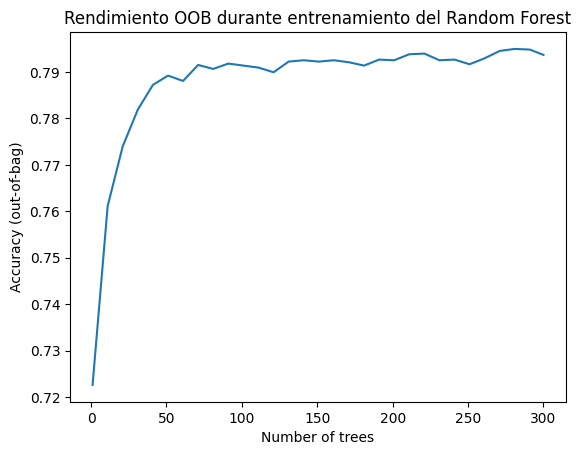

In [17]:


# rf es nuestro modelo Random Forest ya entrenado
# make_inspector nos permite acceder a información interna del modelo
inspector = rf.make_inspector()

# training_logs devuelve la lista de registros de entrenamiento de cada árbol
# Cada log tiene información como número de árboles entrenados y precisión OOB
logs = inspector.training_logs()

# Vamos a crear dos listas:
# 1. Número de árboles entrenados en cada punto
# 2. Precisión calculada sobre los datos Out-of-Bag (OOB) en ese momento
num_trees = [log.num_trees for log in logs]          # Número de árboles hasta ese log
oob_accuracy = [log.evaluation.accuracy for log in logs]  # Precisión sobre OOB

# Ahora podemos visualizar cómo cambia la precisión OOB a medida que aumentamos los árboles
plt.plot(num_trees, oob_accuracy)  # Graficamos número de árboles vs precisión OOB
plt.xlabel("Number of trees")      # Etiqueta eje X
plt.ylabel("Accuracy (out-of-bag)") # Etiqueta eje Y
plt.title("Rendimiento OOB durante entrenamiento del Random Forest") # Título del gráfico
plt.show()  # Mostramos el gráfico


In [18]:
inspector.evaluation()

Evaluation(num_examples=6960, accuracy=0.7936781609195402, loss=0.537789236067061, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

## veamos la importancia de cada variable

In [19]:
print(f"Importancias:")
for importance in inspector.variable_importances().keys():
    print("\t",importance)

Importancias:
	 INV_MEAN_MIN_DEPTH
	 NUM_AS_ROOT
	 NUM_NODES
	 SUM_SCORE


In [20]:
# CADA LINEA ES: nombre,(indice),importancia
inspector.variable_importances()['NUM_AS_ROOT']

[("CryoSleep" (1; #2), 128.0),
 ("RoomService" (1; #7), 62.0),
 ("Spa" (1; #10), 58.0),
 ("VRDeck" (1; #12), 26.0),
 ("ShoppingMall" (1; #8), 15.0),
 ("FoodCourt" (1; #5), 8.0),
 ("Deck" (4; #3), 2.0),
 ("HomePlanet" (4; #6), 1.0)]

In [21]:
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
submission_id = test_df.PassengerId

# reemplazamos nulos con 0 en el conjunto de test
test_df[['VIP','CryoSleep']] = test_df[['VIP','CryoSleep']].fillna(value=0)

test_df[["Deck","Cabin_num","Side"]] = test_df["Cabin"].str.split("/",expand= True)
test_df = test_df.drop('Cabin',axis=1)

# convertimos booleanos a '0's y '1's
test_df['VIP'] = test_df['VIP'].astype(int)
test_df['CryoSleep'] = test_df['CryoSleep'].astype(int)

# convertimos pd dataframe a tf dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df)

# obtenemos predicciones
predicciones = rf.predict(test_ds)
n_predicciones = (predicciones > 0.5).astype(bool)
output=pd.DataFrame({'PassengerID' : submission_id,
                    'Transported' : n_predicciones.squeeze()})
output.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


5/5 [==============================] - 1s 70ms/step


,PassengerID,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [22]:
sample_submission_df = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')
sample_submission_df['Transported'] = n_predicciones
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
